# LSTM - vanilla

In [5]:
best_model = "best_model3.pt"

In [6]:
!pip install torch --upgrade

## Load and prepare data

In [7]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [8]:
train_file = np.load('../cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('../cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


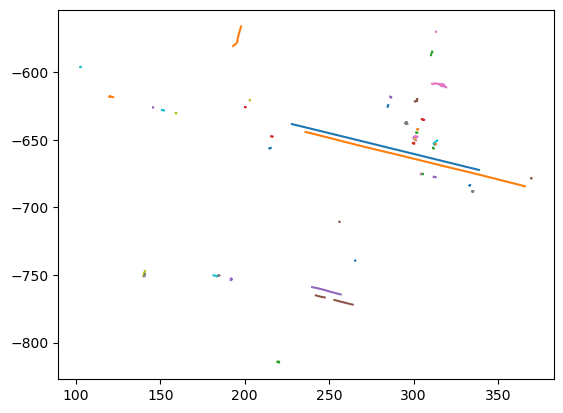

In [9]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [10]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [11]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [12]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=512, output_dim=60*2):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights properly
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        
    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
        # Process through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Extract final hidden state
        features = lstm_out[:, -1, :]
        
        # Process through prediction head
        features = self.relu(self.fc1(features))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

In [26]:
def plot_loss_curves(losses):

    plt.figure()
    plt.plot(range(len(losses[0])), losses[0], label='Training Loss')
    plt.plot(range(len(losses[0])), losses[1], label='Validation Loss')  
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss Curves')
    plt.savefig(f'figures/loss_lstm.png')
    # plt.show()

# Train

In [27]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    train_mae_, val_mae_ = [], []
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        train_mae = 0
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            mae = nn.L1Loss()(pred, y).item()
            train_mae += mae
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        train_mae /= num_train_batches
        train_mae_.append(train_mae)
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        val_mae_.append(val_mae)
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    plot_loss_curves([train_mae_, val_mae_])
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [28]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM(input_dim=6, hidden_dim=512)
    model = model.to(device)
    
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007 => 9.07
        # lr = 0.01 => 9.18
        lr=0.007,  # Lower learning rate
        patience=20,  # More patience
        epochs=100
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_13761/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_13761/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:09<15:31,  9.41s/epoch]

Epoch 000 | LR 0.006650 | Train MSE 1.6178 | Val MSE 0.3969 | Val MAE 2.5378 | Val MSE 19.4462
Sample pred first 3 steps: [[-0.0251976   0.02643282]
 [-0.00233844  0.00110174]
 [ 0.00784496  0.04364465]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: inf -> 0.396861


Epoch:   2%|▏         | 2/100 [00:18<15:23,  9.42s/epoch]

Epoch 001 | LR 0.006317 | Train MSE 0.5750 | Val MSE 0.3711 | Val MAE 2.3391 | Val MSE 18.1817
Validation improved: 0.396861 -> 0.371056


Epoch:   3%|▎         | 3/100 [00:28<15:21,  9.50s/epoch]

Epoch 002 | LR 0.006002 | Train MSE 0.3659 | Val MSE 0.2827 | Val MAE 2.0818 | Val MSE 13.8504
Validation improved: 0.371056 -> 0.282661


Epoch:   4%|▍         | 4/100 [00:37<15:00,  9.38s/epoch]

Epoch 003 | LR 0.005702 | Train MSE 0.7004 | Val MSE 0.3228 | Val MAE 2.2719 | Val MSE 15.8158


Epoch:   5%|▌         | 5/100 [00:46<14:45,  9.32s/epoch]

Epoch 004 | LR 0.005416 | Train MSE 0.3223 | Val MSE 0.3081 | Val MAE 2.2082 | Val MSE 15.0976


Epoch:   6%|▌         | 6/100 [00:55<14:31,  9.27s/epoch]

Epoch 005 | LR 0.005146 | Train MSE 0.3084 | Val MSE 0.2556 | Val MAE 1.8168 | Val MSE 12.5257
Sample pred first 3 steps: [[ 0.00298369  0.00068452]
 [-0.00010955 -0.00288579]
 [-0.00124727  0.00253505]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.282661 -> 0.255627


Epoch:   7%|▋         | 7/100 [01:05<14:24,  9.29s/epoch]

Epoch 006 | LR 0.004888 | Train MSE 0.2866 | Val MSE 0.2406 | Val MAE 1.7939 | Val MSE 11.7903
Validation improved: 0.255627 -> 0.240618


Epoch:   8%|▊         | 8/100 [01:14<14:14,  9.29s/epoch]

Epoch 007 | LR 0.004644 | Train MSE 0.2786 | Val MSE 0.2234 | Val MAE 1.7066 | Val MSE 10.9468
Validation improved: 0.240618 -> 0.223405


Epoch:   9%|▉         | 9/100 [01:23<14:07,  9.31s/epoch]

Epoch 008 | LR 0.004412 | Train MSE 0.2658 | Val MSE 0.2350 | Val MAE 1.8551 | Val MSE 11.5136


Epoch:  10%|█         | 10/100 [01:33<14:00,  9.34s/epoch]

Epoch 009 | LR 0.004191 | Train MSE 0.2583 | Val MSE 0.2000 | Val MAE 1.5563 | Val MSE 9.7981
Validation improved: 0.223405 -> 0.199961


Epoch:  11%|█         | 11/100 [01:42<13:45,  9.27s/epoch]

Epoch 010 | LR 0.003982 | Train MSE 0.2510 | Val MSE 0.2042 | Val MAE 1.5764 | Val MSE 10.0062
Sample pred first 3 steps: [[-0.00112375  0.00574058]
 [ 0.00091023  0.00861167]
 [ 0.0013003   0.01300245]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  12%|█▏        | 12/100 [01:51<13:34,  9.26s/epoch]

Epoch 011 | LR 0.003783 | Train MSE 0.2404 | Val MSE 0.2084 | Val MAE 1.6942 | Val MSE 10.2135


Epoch:  13%|█▎        | 13/100 [02:00<13:20,  9.20s/epoch]

Epoch 012 | LR 0.003593 | Train MSE 0.2411 | Val MSE 0.2243 | Val MAE 1.7821 | Val MSE 10.9931


Epoch:  14%|█▍        | 14/100 [02:10<13:13,  9.23s/epoch]

Epoch 013 | LR 0.003414 | Train MSE 0.2329 | Val MSE 0.2037 | Val MAE 1.6543 | Val MSE 9.9827


Epoch:  15%|█▌        | 15/100 [02:19<13:11,  9.32s/epoch]

Epoch 014 | LR 0.003243 | Train MSE 0.2317 | Val MSE 0.1966 | Val MAE 1.6063 | Val MSE 9.6335
Validation improved: 0.199961 -> 0.196603


Epoch:  16%|█▌        | 16/100 [02:28<12:45,  9.11s/epoch]

Epoch 015 | LR 0.003081 | Train MSE 0.2253 | Val MSE 0.2055 | Val MAE 1.6450 | Val MSE 10.0701
Sample pred first 3 steps: [[-0.00229753 -0.00197269]
 [-0.00380899  0.00124966]
 [-0.00045695 -0.00064894]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  17%|█▋        | 17/100 [02:36<12:16,  8.87s/epoch]

Epoch 016 | LR 0.002927 | Train MSE 0.2285 | Val MSE 0.1968 | Val MAE 1.7010 | Val MSE 9.6446


Epoch:  18%|█▊        | 18/100 [02:45<12:14,  8.95s/epoch]

Epoch 017 | LR 0.002781 | Train MSE 0.2263 | Val MSE 0.1990 | Val MAE 1.6142 | Val MSE 9.7506


Epoch:  19%|█▉        | 19/100 [02:54<11:52,  8.79s/epoch]

Epoch 018 | LR 0.002641 | Train MSE 0.2224 | Val MSE 0.1961 | Val MAE 1.6757 | Val MSE 9.6087
Validation improved: 0.196603 -> 0.196096


Epoch:  20%|██        | 20/100 [03:03<11:47,  8.84s/epoch]

Epoch 019 | LR 0.002509 | Train MSE 0.2179 | Val MSE 0.1834 | Val MAE 1.4633 | Val MSE 8.9876
Validation improved: 0.196096 -> 0.183421


Epoch:  21%|██        | 21/100 [03:12<11:55,  9.06s/epoch]

Epoch 020 | LR 0.002384 | Train MSE 0.2138 | Val MSE 0.1908 | Val MAE 1.5242 | Val MSE 9.3468
Sample pred first 3 steps: [[-0.00024122 -0.00125121]
 [-0.00213927  0.00019811]
 [ 0.00029851  0.00376077]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  22%|██▏       | 22/100 [03:21<11:29,  8.84s/epoch]

Epoch 021 | LR 0.002265 | Train MSE 0.2120 | Val MSE 0.1849 | Val MAE 1.4487 | Val MSE 9.0579


Epoch:  23%|██▎       | 23/100 [03:29<11:16,  8.79s/epoch]

Epoch 022 | LR 0.002151 | Train MSE 0.2134 | Val MSE 0.1843 | Val MAE 1.4615 | Val MSE 9.0313


Epoch:  24%|██▍       | 24/100 [03:38<11:08,  8.79s/epoch]

Epoch 023 | LR 0.002044 | Train MSE 0.2103 | Val MSE 0.1941 | Val MAE 1.5882 | Val MSE 9.5112


Epoch:  25%|██▌       | 25/100 [03:46<10:53,  8.71s/epoch]

Epoch 024 | LR 0.001942 | Train MSE 0.2075 | Val MSE 0.1793 | Val MAE 1.4901 | Val MSE 8.7871
Validation improved: 0.183421 -> 0.179330


Epoch:  26%|██▌       | 26/100 [03:55<10:48,  8.76s/epoch]

Epoch 025 | LR 0.001845 | Train MSE 0.2048 | Val MSE 0.1787 | Val MAE 1.4079 | Val MSE 8.7559
Sample pred first 3 steps: [[0.00562914 0.00055359]
 [0.00337262 0.00361259]
 [0.0017115  0.00552165]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.179330 -> 0.178692


Epoch:  27%|██▋       | 27/100 [04:04<10:27,  8.60s/epoch]

Epoch 026 | LR 0.001752 | Train MSE 0.2064 | Val MSE 0.1816 | Val MAE 1.5113 | Val MSE 8.8970


Epoch:  28%|██▊       | 28/100 [04:12<10:11,  8.50s/epoch]

Epoch 027 | LR 0.001665 | Train MSE 0.2029 | Val MSE 0.1835 | Val MAE 1.4645 | Val MSE 8.9893


Epoch:  29%|██▉       | 29/100 [04:21<10:09,  8.59s/epoch]

Epoch 028 | LR 0.001582 | Train MSE 0.2015 | Val MSE 0.1798 | Val MAE 1.4579 | Val MSE 8.8101


Epoch:  30%|███       | 30/100 [04:29<09:56,  8.52s/epoch]

Epoch 029 | LR 0.001502 | Train MSE 0.2001 | Val MSE 0.1778 | Val MAE 1.4224 | Val MSE 8.7113
Validation improved: 0.178692 -> 0.177781


Epoch:  31%|███       | 31/100 [04:38<09:56,  8.64s/epoch]

Epoch 030 | LR 0.001427 | Train MSE 0.1995 | Val MSE 0.1841 | Val MAE 1.4387 | Val MSE 9.0223
Sample pred first 3 steps: [[-6.2588137e-05  1.7512556e-03]
 [-1.2297384e-03  2.7133692e-03]
 [-1.4157156e-03  2.4726070e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  32%|███▏      | 32/100 [04:46<09:40,  8.54s/epoch]

Epoch 031 | LR 0.001356 | Train MSE 0.1983 | Val MSE 0.1772 | Val MAE 1.4172 | Val MSE 8.6820
Validation improved: 0.177781 -> 0.177184


Epoch:  33%|███▎      | 33/100 [04:55<09:31,  8.53s/epoch]

Epoch 032 | LR 0.001288 | Train MSE 0.1976 | Val MSE 0.1769 | Val MAE 1.4454 | Val MSE 8.6671
Validation improved: 0.177184 -> 0.176880


Epoch:  34%|███▍      | 34/100 [05:04<09:31,  8.67s/epoch]

Epoch 033 | LR 0.001224 | Train MSE 0.1954 | Val MSE 0.1779 | Val MAE 1.4655 | Val MSE 8.7168


Epoch:  35%|███▌      | 35/100 [05:12<09:16,  8.56s/epoch]

Epoch 034 | LR 0.001163 | Train MSE 0.1949 | Val MSE 0.1787 | Val MAE 1.4591 | Val MSE 8.7571


Epoch:  36%|███▌      | 36/100 [05:21<09:13,  8.65s/epoch]

Epoch 035 | LR 0.001104 | Train MSE 0.1933 | Val MSE 0.1773 | Val MAE 1.4554 | Val MSE 8.6854
Sample pred first 3 steps: [[-0.00267054  0.00326843]
 [-0.00664144  0.00343395]
 [-0.00553635  0.00194028]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  37%|███▋      | 37/100 [05:30<09:07,  8.69s/epoch]

Epoch 036 | LR 0.001049 | Train MSE 0.1907 | Val MSE 0.1774 | Val MAE 1.4270 | Val MSE 8.6904


Epoch:  38%|███▊      | 38/100 [05:38<08:53,  8.61s/epoch]

Epoch 037 | LR 0.000997 | Train MSE 0.1904 | Val MSE 0.1714 | Val MAE 1.3752 | Val MSE 8.3981
Validation improved: 0.176880 -> 0.171390


Epoch:  39%|███▉      | 39/100 [05:47<08:52,  8.72s/epoch]

Epoch 038 | LR 0.000947 | Train MSE 0.1879 | Val MSE 0.1706 | Val MAE 1.3851 | Val MSE 8.3581
Validation improved: 0.171390 -> 0.170574


Epoch:  40%|████      | 40/100 [05:56<08:38,  8.64s/epoch]

Epoch 039 | LR 0.000900 | Train MSE 0.1913 | Val MSE 0.1687 | Val MAE 1.3659 | Val MSE 8.2657
Validation improved: 0.170574 -> 0.168687


Epoch:  41%|████      | 41/100 [06:04<08:34,  8.71s/epoch]

Epoch 040 | LR 0.000855 | Train MSE 0.1874 | Val MSE 0.1720 | Val MAE 1.4081 | Val MSE 8.4280
Sample pred first 3 steps: [[-0.00048573 -0.001673  ]
 [ 0.0012492   0.00170895]
 [-0.00012359  0.00493167]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  42%|████▏     | 42/100 [06:13<08:21,  8.65s/epoch]

Epoch 041 | LR 0.000812 | Train MSE 0.1868 | Val MSE 0.1775 | Val MAE 1.4306 | Val MSE 8.6980


Epoch:  43%|████▎     | 43/100 [06:21<08:08,  8.57s/epoch]

Epoch 042 | LR 0.000771 | Train MSE 0.1893 | Val MSE 0.1659 | Val MAE 1.3479 | Val MSE 8.1278
Validation improved: 0.168687 -> 0.165874


Epoch:  44%|████▍     | 44/100 [06:30<08:04,  8.64s/epoch]

Epoch 043 | LR 0.000733 | Train MSE 0.1844 | Val MSE 0.1718 | Val MAE 1.3592 | Val MSE 8.4170


Epoch:  45%|████▌     | 45/100 [06:38<07:50,  8.55s/epoch]

Epoch 044 | LR 0.000696 | Train MSE 0.1837 | Val MSE 0.1666 | Val MAE 1.4019 | Val MSE 8.1652


Epoch:  46%|████▌     | 46/100 [06:47<07:44,  8.59s/epoch]

Epoch 045 | LR 0.000661 | Train MSE 0.1878 | Val MSE 0.1666 | Val MAE 1.3607 | Val MSE 8.1634
Sample pred first 3 steps: [[ 0.00056034  0.00027916]
 [-0.00048891 -0.00029133]
 [-0.00033671  0.00023007]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  47%|████▋     | 47/100 [06:56<07:37,  8.62s/epoch]

Epoch 046 | LR 0.000628 | Train MSE 0.1845 | Val MSE 0.1662 | Val MAE 1.3280 | Val MSE 8.1429


Epoch:  48%|████▊     | 48/100 [07:04<07:23,  8.54s/epoch]

Epoch 047 | LR 0.000597 | Train MSE 0.1824 | Val MSE 0.1727 | Val MAE 1.4014 | Val MSE 8.4633


Epoch:  49%|████▉     | 49/100 [07:13<07:19,  8.62s/epoch]

Epoch 048 | LR 0.000567 | Train MSE 0.1810 | Val MSE 0.1694 | Val MAE 1.4009 | Val MSE 8.3018


Epoch:  50%|█████     | 50/100 [07:21<07:06,  8.52s/epoch]

Epoch 049 | LR 0.000539 | Train MSE 0.1836 | Val MSE 0.1676 | Val MAE 1.3569 | Val MSE 8.2106


Epoch:  51%|█████     | 51/100 [07:30<07:01,  8.61s/epoch]

Epoch 050 | LR 0.000512 | Train MSE 0.1817 | Val MSE 0.1671 | Val MAE 1.3345 | Val MSE 8.1889
Sample pred first 3 steps: [[ 0.00028453 -0.00047351]
 [-0.00033356 -0.00203618]
 [-0.00104627 -0.00362796]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  52%|█████▏    | 52/100 [07:39<06:53,  8.62s/epoch]

Epoch 051 | LR 0.000486 | Train MSE 0.1839 | Val MSE 0.1696 | Val MAE 1.3725 | Val MSE 8.3093


Epoch:  53%|█████▎    | 53/100 [07:47<06:41,  8.55s/epoch]

Epoch 052 | LR 0.000462 | Train MSE 0.1807 | Val MSE 0.1689 | Val MAE 1.3732 | Val MSE 8.2744


Epoch:  54%|█████▍    | 54/100 [07:56<06:40,  8.71s/epoch]

Epoch 053 | LR 0.000439 | Train MSE 0.1802 | Val MSE 0.1674 | Val MAE 1.3423 | Val MSE 8.2012


Epoch:  55%|█████▌    | 55/100 [08:04<06:25,  8.57s/epoch]

Epoch 054 | LR 0.000417 | Train MSE 0.1792 | Val MSE 0.1658 | Val MAE 1.3677 | Val MSE 8.1247
Validation improved: 0.165874 -> 0.165811


Epoch:  56%|█████▌    | 56/100 [08:13<06:17,  8.58s/epoch]

Epoch 055 | LR 0.000396 | Train MSE 0.1787 | Val MSE 0.1651 | Val MAE 1.3217 | Val MSE 8.0901
Sample pred first 3 steps: [[-7.0997048e-05 -1.4897261e-03]
 [-5.8835372e-04 -2.4158999e-03]
 [ 1.5494693e-04 -3.1756740e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.165811 -> 0.165104


Epoch:  57%|█████▋    | 57/100 [08:22<06:12,  8.67s/epoch]

Epoch 056 | LR 0.000376 | Train MSE 0.1789 | Val MSE 0.1650 | Val MAE 1.3584 | Val MSE 8.0826
Validation improved: 0.165104 -> 0.164952


Epoch:  58%|█████▊    | 58/100 [08:30<06:00,  8.59s/epoch]

Epoch 057 | LR 0.000357 | Train MSE 0.1782 | Val MSE 0.1640 | Val MAE 1.3242 | Val MSE 8.0364
Validation improved: 0.164952 -> 0.164008


Epoch:  59%|█████▉    | 59/100 [08:40<06:01,  8.83s/epoch]

Epoch 058 | LR 0.000339 | Train MSE 0.1771 | Val MSE 0.1657 | Val MAE 1.3566 | Val MSE 8.1194


Epoch:  60%|██████    | 60/100 [08:49<05:52,  8.82s/epoch]

Epoch 059 | LR 0.000322 | Train MSE 0.1778 | Val MSE 0.1652 | Val MAE 1.3561 | Val MSE 8.0964


Epoch:  61%|██████    | 61/100 [08:57<05:40,  8.73s/epoch]

Epoch 060 | LR 0.000306 | Train MSE 0.1788 | Val MSE 0.1665 | Val MAE 1.3243 | Val MSE 8.1584
Sample pred first 3 steps: [[ 0.00154492 -0.00209274]
 [ 0.00415904 -0.00382202]
 [ 0.00580361 -0.00578803]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  62%|██████▏   | 62/100 [09:06<05:34,  8.79s/epoch]

Epoch 061 | LR 0.000291 | Train MSE 0.1764 | Val MSE 0.1672 | Val MAE 1.3294 | Val MSE 8.1922


Epoch:  63%|██████▎   | 63/100 [09:14<05:22,  8.71s/epoch]

Epoch 062 | LR 0.000276 | Train MSE 0.1788 | Val MSE 0.1644 | Val MAE 1.3301 | Val MSE 8.0540


Epoch:  64%|██████▍   | 64/100 [09:24<05:17,  8.82s/epoch]

Epoch 063 | LR 0.000263 | Train MSE 0.1749 | Val MSE 0.1641 | Val MAE 1.3250 | Val MSE 8.0400


Epoch:  65%|██████▌   | 65/100 [09:32<05:05,  8.72s/epoch]

Epoch 064 | LR 0.000250 | Train MSE 0.1781 | Val MSE 0.1632 | Val MAE 1.3196 | Val MSE 7.9973
Validation improved: 0.164008 -> 0.163210


Epoch:  66%|██████▌   | 66/100 [09:40<04:52,  8.61s/epoch]

Epoch 065 | LR 0.000237 | Train MSE 0.1770 | Val MSE 0.1646 | Val MAE 1.3215 | Val MSE 8.0672
Sample pred first 3 steps: [[ 3.3931807e-05 -1.5486937e-03]
 [ 8.5903471e-04 -3.2647089e-03]
 [ 1.5078736e-03 -3.8713315e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  67%|██████▋   | 67/100 [09:50<04:50,  8.79s/epoch]

Epoch 066 | LR 0.000225 | Train MSE 0.1752 | Val MSE 0.1633 | Val MAE 1.3259 | Val MSE 8.0025


Epoch:  68%|██████▊   | 68/100 [09:58<04:37,  8.67s/epoch]

Epoch 067 | LR 0.000214 | Train MSE 0.1739 | Val MSE 0.1648 | Val MAE 1.3440 | Val MSE 8.0747


Epoch:  69%|██████▉   | 69/100 [10:07<04:29,  8.69s/epoch]

Epoch 068 | LR 0.000203 | Train MSE 0.1749 | Val MSE 0.1620 | Val MAE 1.3162 | Val MSE 7.9359
Validation improved: 0.163210 -> 0.161957


Epoch:  70%|███████   | 70/100 [10:15<04:18,  8.63s/epoch]

Epoch 069 | LR 0.000193 | Train MSE 0.1769 | Val MSE 0.1621 | Val MAE 1.3092 | Val MSE 7.9422


Epoch:  71%|███████   | 71/100 [10:24<04:08,  8.56s/epoch]

Epoch 070 | LR 0.000183 | Train MSE 0.1743 | Val MSE 0.1627 | Val MAE 1.3232 | Val MSE 7.9712
Sample pred first 3 steps: [[-0.00042167 -0.00042388]
 [-0.00119761  0.00051781]
 [-0.00121883  0.00061883]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  72%|███████▏  | 72/100 [10:33<04:10,  8.94s/epoch]

Epoch 071 | LR 0.000174 | Train MSE 0.1724 | Val MSE 0.1634 | Val MAE 1.3189 | Val MSE 8.0048


Epoch:  73%|███████▎  | 73/100 [10:43<04:05,  9.08s/epoch]

Epoch 072 | LR 0.000166 | Train MSE 0.1719 | Val MSE 0.1645 | Val MAE 1.3346 | Val MSE 8.0608


Epoch:  74%|███████▍  | 74/100 [10:52<04:00,  9.24s/epoch]

Epoch 073 | LR 0.000157 | Train MSE 0.1747 | Val MSE 0.1629 | Val MAE 1.3249 | Val MSE 7.9830


Epoch:  75%|███████▌  | 75/100 [11:01<03:47,  9.10s/epoch]

Epoch 074 | LR 0.000149 | Train MSE 0.1758 | Val MSE 0.1637 | Val MAE 1.3307 | Val MSE 8.0230


Epoch:  76%|███████▌  | 76/100 [11:08<03:23,  8.49s/epoch]

Epoch 075 | LR 0.000142 | Train MSE 0.1755 | Val MSE 0.1639 | Val MAE 1.3245 | Val MSE 8.0324
Sample pred first 3 steps: [[ 4.9515604e-04  7.2524417e-05]
 [-3.0517019e-04  4.1905558e-04]
 [-2.8520077e-04  9.2178397e-04]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  77%|███████▋  | 77/100 [11:17<03:19,  8.65s/epoch]

Epoch 076 | LR 0.000135 | Train MSE 0.1729 | Val MSE 0.1623 | Val MAE 1.3168 | Val MSE 7.9515


Epoch:  78%|███████▊  | 78/100 [11:27<03:14,  8.84s/epoch]

Epoch 077 | LR 0.000128 | Train MSE 0.1720 | Val MSE 0.1633 | Val MAE 1.3239 | Val MSE 8.0038


Epoch:  79%|███████▉  | 79/100 [11:35<03:04,  8.79s/epoch]

Epoch 078 | LR 0.000122 | Train MSE 0.1713 | Val MSE 0.1633 | Val MAE 1.3059 | Val MSE 8.0019


Epoch:  80%|████████  | 80/100 [11:43<02:50,  8.51s/epoch]

Epoch 079 | LR 0.000116 | Train MSE 0.1724 | Val MSE 0.1626 | Val MAE 1.3089 | Val MSE 7.9674


Epoch:  81%|████████  | 81/100 [11:51<02:39,  8.40s/epoch]

Epoch 080 | LR 0.000110 | Train MSE 0.1721 | Val MSE 0.1645 | Val MAE 1.3427 | Val MSE 8.0592
Sample pred first 3 steps: [[ 4.0450622e-04 -1.9914121e-04]
 [ 1.3886783e-03 -2.5866786e-04]
 [ 2.5755158e-03 -7.2933268e-05]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  82%|████████▏ | 82/100 [12:00<02:31,  8.41s/epoch]

Epoch 081 | LR 0.000104 | Train MSE 0.1717 | Val MSE 0.1627 | Val MAE 1.3073 | Val MSE 7.9744


Epoch:  83%|████████▎ | 83/100 [12:07<02:18,  8.16s/epoch]

Epoch 082 | LR 0.000099 | Train MSE 0.1734 | Val MSE 0.1642 | Val MAE 1.3290 | Val MSE 8.0471


Epoch:  84%|████████▍ | 84/100 [12:15<02:08,  8.05s/epoch]

Epoch 083 | LR 0.000094 | Train MSE 0.1726 | Val MSE 0.1623 | Val MAE 1.3079 | Val MSE 7.9527


Epoch:  85%|████████▌ | 85/100 [12:24<02:03,  8.25s/epoch]

Epoch 084 | LR 0.000089 | Train MSE 0.1715 | Val MSE 0.1630 | Val MAE 1.3097 | Val MSE 7.9894


Epoch:  86%|████████▌ | 86/100 [12:31<01:52,  8.02s/epoch]

Epoch 085 | LR 0.000085 | Train MSE 0.1721 | Val MSE 0.1622 | Val MAE 1.3114 | Val MSE 7.9484
Sample pred first 3 steps: [[ 0.00029037 -0.00060263]
 [ 0.00075068 -0.00074034]
 [ 0.00095921 -0.00091025]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  87%|████████▋ | 87/100 [12:39<01:42,  7.86s/epoch]

Epoch 086 | LR 0.000081 | Train MSE 0.1730 | Val MSE 0.1625 | Val MAE 1.3154 | Val MSE 7.9619


Epoch:  88%|████████▊ | 88/100 [12:48<01:37,  8.14s/epoch]

Epoch 087 | LR 0.000077 | Train MSE 0.1715 | Val MSE 0.1630 | Val MAE 1.3103 | Val MSE 7.9869


Epoch:  88%|████████▊ | 88/100 [12:55<01:45,  8.81s/epoch]


Epoch 088 | LR 0.000073 | Train MSE 0.1727 | Val MSE 0.1624 | Val MAE 1.3082 | Val MSE 7.9555
Early stopping after 89 epochs without improvement
Val MSE: 7.9359


SimpleLSTM(
  (lstm): LSTM(6, 512, batch_first=True)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=120, bias=True)
)

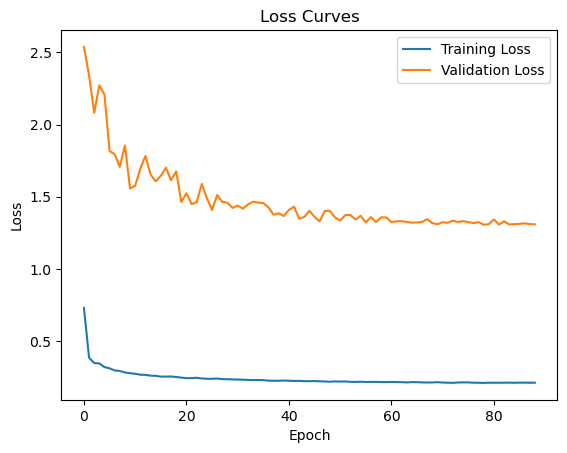

In [29]:
train_and_evaluate_model()

In [32]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

/var/folders/0r/zhth93bs1ygg_ln8t_nhb4f80000gn/T/ipykernel_13761/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


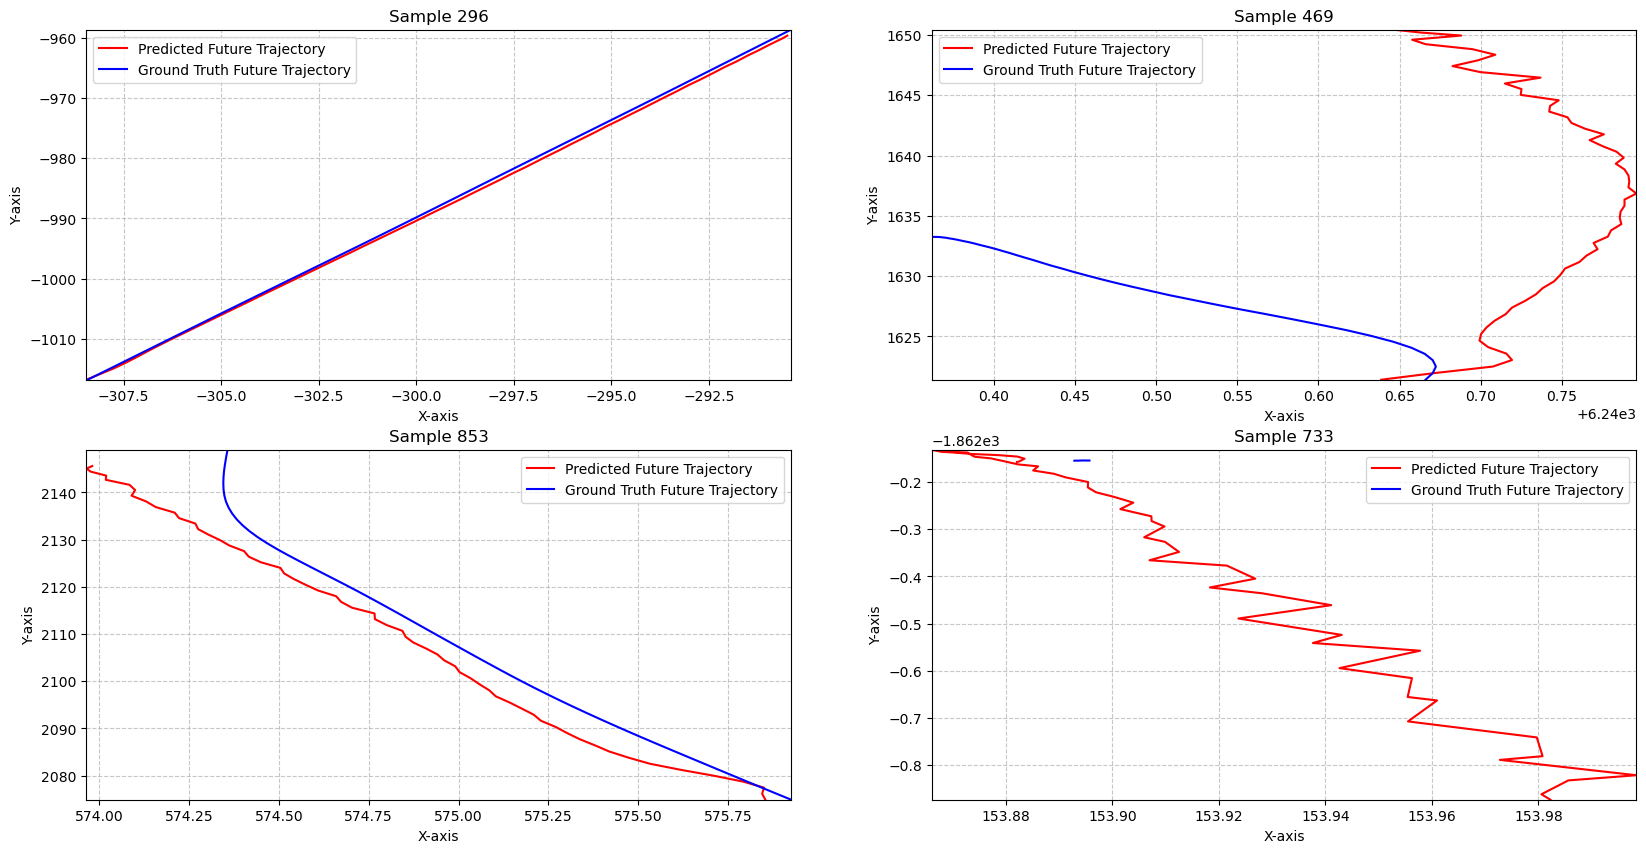

In [34]:
model = SimpleLSTM(input_dim=6, hidden_dim=512)
model = model.to(device)
model.load_state_dict(torch.load("best_model3.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

# Final Pred

In [119]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto4.csv', index=True)

/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_49283/3021567481.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model2 = torch.load(best_model)
